In [18]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

Transfomer for preprocessing images before feeding to model

In [7]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Loading Data and applying transformation at the same time

In [ ]:
dataset = datasets.ImageFolder(root="CNN letter Dataset", transform=transform)

In [23]:
from torch.utils.data import random_split


train_size = int(0.8 * len(dataset))  
test_size = len(dataset) - train_size  
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)  #Batch size is specified so mini batch is done
test_loader = DataLoader(test_dataset, batch_size=40, shuffle=False)


In [25]:
image, label = next(iter(train_loader))  # Checking if loading was proper.Next(iter()) - >used to retrieve next mini batch.
print(image.shape, label)        # (Batch size, no of channel, #pixels,#pixels), Label as class index

torch.Size([40, 1, 32, 32]) tensor([30,  1, 30,  0, 27,  2,  1, 17, 30, 33,  6, 14,  9, 23,  9,  5, 29, 21,
        28, 11, 34,  4,  6, 28, 14, 21,  8, 16, 10, 23, 16,  9, 33, 22, 26, 34,
        13, 28,  1, 26])


Model definition

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1) #in - 32*32*1, out - 32*32*32
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  #in - 32*32*32, out - 16*16*32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  #in - 16*16*32, out - 16*16*64
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  #in - 16*16*64, out - 8*8*64
        self.fc1 = nn.Linear(8 * 8 * 64, 128)  
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 36)  

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)  
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)  
        
        
        x = x.view(x.size(0), -1)  
        
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)  
        
        return x  # Raw logits,not probability as cross entropyloss requires this only


In [27]:
CNN_OCR_model = SimpleCNN()

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_OCR_model.parameters(), lr = 0.001)

In [29]:
epochs = 10
losses = []

for epoch in range(epochs):
    CNN_OCR_model.train()  
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = CNN_OCR_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, axis=1) #Gives max value and its corresponding index as output
 
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    # Print stats for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total * 100
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
    losses.append(epoch_loss)

Epoch 1/10, Loss: 0.3737, Accuracy: 89.21%
Epoch 2/10, Loss: 0.0326, Accuracy: 99.07%
Epoch 3/10, Loss: 0.0212, Accuracy: 99.39%
Epoch 4/10, Loss: 0.0118, Accuracy: 99.71%
Epoch 5/10, Loss: 0.0086, Accuracy: 99.78%
Epoch 6/10, Loss: 0.0159, Accuracy: 99.56%
Epoch 7/10, Loss: 0.0039, Accuracy: 99.92%
Epoch 8/10, Loss: 0.0001, Accuracy: 100.00%
Epoch 9/10, Loss: 0.0179, Accuracy: 99.49%
Epoch 10/10, Loss: 0.0025, Accuracy: 99.95%


Model evaluation

In [30]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

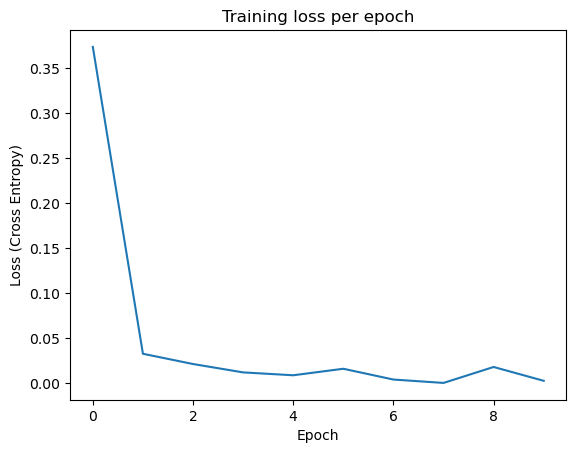

In [31]:
plt.plot(losses)
plt.title("Training loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss (Cross Entropy)")
plt.show()

In [33]:
CNN_OCR_model.eval()

correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in test_loader:  
        outputs = CNN_OCR_model(inputs)
        _, predicted = torch.max(outputs,axis = 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 99.96%


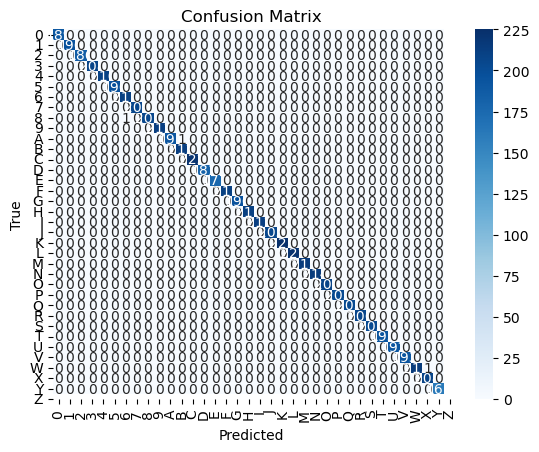

In [34]:
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',  # Digits first
                'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 
                'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 
                'U', 'V', 'W', 'X', 'Y', 'Z']

cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [35]:
report = classification_report(all_labels, all_predictions)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00       196
           2       1.00      1.00      1.00       186
           3       1.00      1.00      1.00       208
           4       1.00      1.00      1.00       210
           5       1.00      1.00      1.00       196
           6       1.00      1.00      1.00       211
           7       1.00      1.00      1.00       205
           8       1.00      1.00      1.00       206
           9       1.00      1.00      1.00       212
          10       1.00      0.99      1.00       192
          11       1.00      1.00      1.00       212
          12       1.00      1.00      1.00       222
          13       1.00      1.00      1.00       181
          14       1.00      1.00      1.00       177
          15       1.00      1.00      1.00       211
          16       1.00      1.00      1.00       196
    